In [2]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
import plotly.express as px
# Use Plotly's "make_subplots" function from "plotly.subplots" to layout elements horizontally
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load credentials
load_dotenv()

True

In [3]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT') + '.' + os.getenv('SNOWFLAKE_REGION'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database='WALMART_DB',
    schema='SILVER',
    role=os.getenv('SNOWFLAKE_ROLE')
)

In [4]:
# Setup Pandas display
pd.set_option('display.width', 1500)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)


In [5]:
# SQL query
# Aggregate the fuel cost per store and year, then pivot the data to show
# the aggregated totals for fuel as columns
sql = """
WITH ByStoreYear AS (
    SELECT
        wft.store_id,
        wdd.year,
        COALESCE(SUM(wft.fuel_price), 0) AS fuel_price
    FROM
        WALMART_DB.SILVER.walmart_fact_table wft
    JOIN
        WALMART_DB.SILVER.walmart_date_dim wdd
    ON
        wft.date_id = wdd.date_id
    GROUP BY
        1,2
    ORDER BY
        1,2
)
SELECT
    store_id,
    SUM(CASE WHEN year = 2010 THEN fuel_price ELSE 0 END) AS total_fuel_2010,
    SUM(CASE WHEN year = 2011 THEN fuel_price ELSE 0 END) AS total_fuel_2011,
    SUM(CASE WHEN year = 2012 THEN fuel_price ELSE 0 END) AS total_fuel_2012
FROM
    ByStoreYear
GROUP BY
    store_id
ORDER BY
    store_id
"""

# Run query using Snowflake connector
cur = conn.cursor()
cur.execute(sql)

# Load results into DataFrame
columns = [col[0] for col in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data, columns=columns)

# Force column names to lowercase so Snowflake will match the model table
df.columns = [col.lower() for col in df.columns]

# print(df.columns)

In [6]:
# Add a total column on the right
df['total_fuel_cost'] = df['total_fuel_2010'] + df['total_fuel_2011'] + df['total_fuel_2012']
print(df.head(10))

   store_id  total_fuel_2010  total_fuel_2011  total_fuel_2012  total_fuel_cost
0         1         9284.979        12771.890        10916.626        32973.495
1         2         9245.150        12782.526        10937.642        32965.318
2         3         8183.110        11240.638         9664.151        29087.899
3         4         9346.496        12745.047        10945.646        33037.189
4         5         8080.029        11328.856         9576.103        28984.988
5         6         9195.630        12781.186        10912.582        32889.398
6         7         8939.609        12163.495        10525.631        31628.735
7         8         8969.844        12326.691        10557.981        31854.516
8         9         7871.200        11158.782         9556.457        28586.439
9        10        10637.026        13985.863        12227.342        36850.231


In [7]:
# Now add a total row on the bottom, ignoring the first column (store_id)

# Create a "totals" series to hold the totals of all numeric columns
totals_series = df.iloc[:, 1:].sum(numeric_only=True)
# print(totals_series)
# Think of the series as a list of key:value pairs where the key is the
# column name.
# Create a list that can be appended to the dataframe.
totals_list = ['Total'] + totals_series.tolist()
# print(totals_list)

# Now, append to the dataframe
df.loc[len(df.index)] = totals_list
print(df.tail(10))


   store_id  total_fuel_2010  total_fuel_2011  total_fuel_2012  total_fuel_cost
36       37         6252.401         9042.335         8005.673        23300.409
37       38         7327.520        10098.037         9205.469        26631.026
38       39         8962.415        12317.815        10521.801        31802.031
39       40         9584.961        13377.151        11531.203        34493.315
40       41         9107.187        12634.774        10990.197        32732.158
41       42         6800.499         9408.402         8758.105        24967.006
42       43         6150.929         8392.442         7182.082        21725.453
43       44         6650.444         9009.008         7956.838        23616.290
44       45         9224.659        12738.585        10986.290        32949.534
45    Total       397257.589       546807.273       472843.091      1416907.953


In [8]:
# Format the numbers for presentation

# Figure out if we have mixed types in our columns
for col in df.columns[1:]:
    print(f"{col}: {df[col].map(type).value_counts()}")

# for col in df.columns[1:]:
#     df[col] = df[col].apply(lambda x: f"{x:,.2f}")

total_fuel_2010: total_fuel_2010
<class 'float'>    46
Name: count, dtype: int64
total_fuel_2011: total_fuel_2011
<class 'float'>    46
Name: count, dtype: int64
total_fuel_2012: total_fuel_2012
<class 'float'>    46
Name: count, dtype: int64
total_fuel_cost: total_fuel_cost
<class 'float'>    46
Name: count, dtype: int64


In [9]:
# Pull only the total fuel cost for the dashboard report
total_fuel_cost = df.iloc[-1, -1]
print(f"Total Fuel Cost: {total_fuel_cost}")

Total Fuel Cost: 1416907.9530000002


In [10]:
# Build a dataframe for the pie chart
total_row = df.iloc[len(df)-1]
# print(total_row['total_fuel_2010'])
total_data = {
    'year':['2010','2011','2012'],
    'total_fuel':[total_row['total_fuel_2010'], total_row['total_fuel_2011'],total_row['total_fuel_2012']]
}
df_totals_by_year = pd.DataFrame(total_data)
print(df_totals_by_year)


   year  total_fuel
0  2010  397257.589
1  2011  546807.273
2  2012  472843.091


In [11]:
fill_colors = [
    ['white' if i % 2 == 0 else '#f2f2f2' for i in range(len(df.index) - 1)] + ['white']
    for _ in range(5)
]
# print(fill_colors)

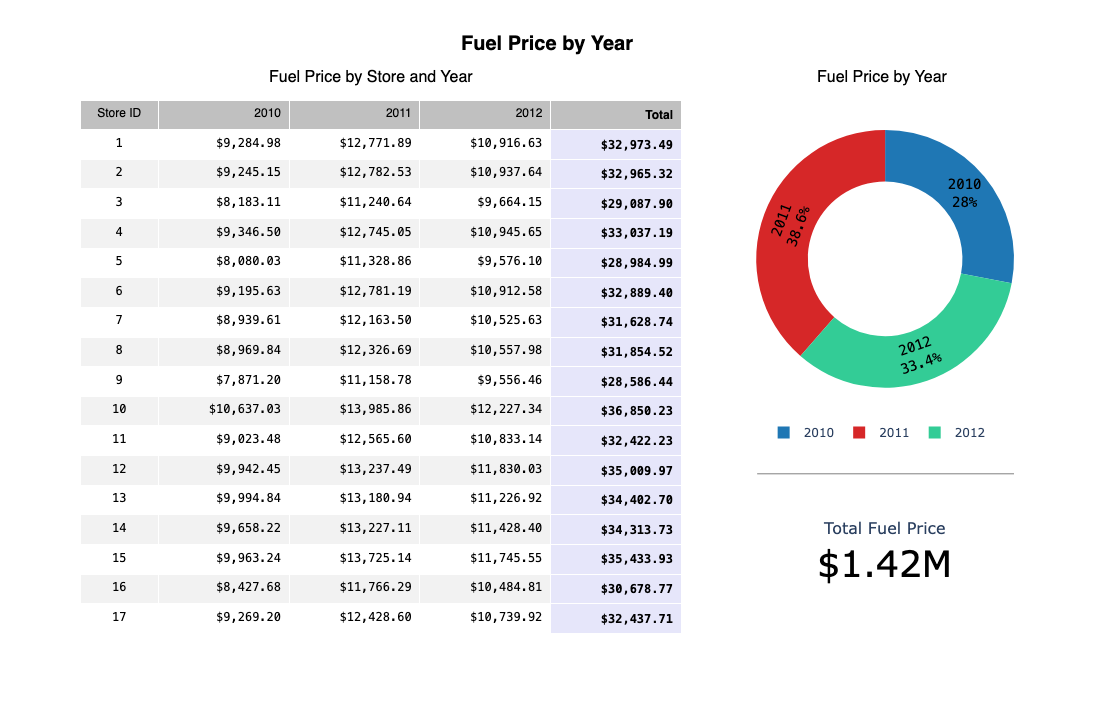

In [19]:
# Let's create a dashboard-style presentation

# First, set up the overall container for the charts.  Here, we have a 3-row, 2-column
# layout where row1,col2 spans 3 rows
fig = make_subplots(
    rows=2,
    cols=2,
    specs=[
        [{'type':"indicator", 't':0, 'b':0, "rowspan": 2}, {"type": "domain"}],
        [ None,                                            {"type": "indicator", 't':0.03}]
    ],
    column_widths=[0.70, 0.30],
    row_heights=[0.70, 0.30],
    horizontal_spacing = 0.08,
    vertical_spacing = 0.15
)

# ========================================

# First, let's add the summary table for fuel prices by store and year
# We have previously generated the dataframe with a total column on the
# right and a total row at the bottom.  We only need to format the table.
df_fmt = df.copy()
for col in df_fmt.columns[1:]:
    df_fmt[col] = df_fmt[col].apply(lambda x: f"${x:,.2f}")
    
# First, lets add zebra striping
# Alternate row colors: white for even, light gray for odd.
# We build color lists for each column, with the last row (the total row) as white.
fill_colors = [
    ['white' if i % 2 == 0 else '#f2f2f2' for i in range(len(df.index) - 1)] + ['white']
    for _ in range(5)
]

# Overwrite the fill color of the last column (the total_fuel_cost column)
for i in range(len(fill_colors[-1])):
    fill_colors[-1][i] = 'lavender'

# Overwrite the final row (the Total row) to a distinct color for emphasis as well
for i in range(len(fill_colors)):
    fill_colors[i][-1] = 'lavender'

# Now add a bold tag to the total row.  Loop through each column in the last row
# and surround it with the <b></b> tags. Don't be confused by the statement:
# df_weekly_sales.iloc[-1][col]
# This is chaining 2 statements together to fetch the last row first (as a series), then
# fetching the label-based element associated with the variable "col" to get the specific
# element.
for col in df_fmt.columns:
    df_fmt.loc[len(df_fmt)-1, col] = f"<b>{df_fmt.iloc[-1][col]}</b>"

# Need to bold the entire total column as well.
for row in range(len(df_fmt)):
    df_fmt.iloc[row,-1] = f"<b>{df_fmt.iloc[row,-1]}</b>"

# Gather the header values for the summary data
column_map = {
    'store_id': 'Store ID',
    'total_fuel_2010': '2010',
    'total_fuel_2011': '2011',
    'total_fuel_2012': '2012',
    'total_fuel_cost': '<b>Total</b>'
}

formatted_headers = [column_map[col] for col in df_fmt.columns]

# Gather the cell values for the summary data
cell_values = [df_fmt[col] for col in df_fmt.columns]

fuel_cost_by_store_year = go.Table(
    columnwidth=[18,30,30,30,30],
    header = dict(
        values = formatted_headers,
        fill_color = '#C0C0C0',
        align = ['center','right','right','right','right'],
        font = dict(size=12,family="Helvetica", color='black')
    ),
    cells = dict(
        values = cell_values,
        align = ['center','right','right','right','right'],
        fill_color = fill_colors,
        font = dict(size=12, family="Menlo", color='black')
    )
)

fig.add_trace(fuel_cost_by_store_year, row=1, col=1)

# Add a nice header to the cell
fig.add_annotation(
    text = "Fuel Price by Store and Year",
    x = 0.2,  # roughly center of line chart
    y = 1.065,  # above the line chart
    xref = "paper",
    yref = "paper",
    showarrow = False,
    font = dict(size=16, family="Helvetica", color="black")
)

# ========================================

# Next, let's add the donut chart to row1, col2
# Extract the existing fuel totals from the summary table dataframe
total_row = df.iloc[len(df)-1]

total_data = {
    'year':['2010','2011','2012'],
    'total_fuel':[total_row['total_fuel_2010'], total_row['total_fuel_2011'],total_row['total_fuel_2012']]
}

df_totals_by_year = pd.DataFrame(total_data)

fuel_price_by_year_trace = go.Pie(
    labels = df_totals_by_year['year'],
    values = df_totals_by_year['total_fuel'],
    textinfo = 'label+percent',
    hovertemplate = 'Year: %{label}<br>Total Fuel Sales: %{value:$,.2f}<extra></extra>',
    hole = 0.6,
    sort = False,    # keep Plotly from sorting the legend values - use the order I created.
    textfont = dict(size=14, family="Menlo", color="black"),
    marker = dict(colors=['#1f77b4', '#d62728', '#33CC96'])
)

fig.add_trace(fuel_price_by_year_trace, row=1, col=2)

fig.add_annotation(
    text = "Fuel Price by Year",
    x = 0.93,  # roughly center of line chart
    y = 1.065,  # above the line chart
    xref = "paper",
    yref = "paper",
    showarrow = False,
    font = dict(size=16, family="Helvetica", color="black")
)

# ========================================

# Next, let's add the total fuel price in row2, col2
# Pull only the total fuel cost for the dashboard report

def formatTotalFuelSales(value):
    if value >= 1_000_000_000:
        return f"${value / 1_000_000_000:.2f}B"
    elif value >= 1_000_000:
        return f"${value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"${value / 1_000:.2f}K"
    else:
        return f"${value:2f}"
        
total_fuel_cost = df.iloc[-1, -1]
totalFuelCostFormattedStr = formatTotalFuelSales(total_fuel_cost)

total_fuel_cost_indicator = go.Table(
    header = dict(
        values = ["Total Fuel Price"],
        fill_color = 'white',
        align = 'center',
        font = dict(size=16)
    ),
    cells = dict(
        values = [totalFuelCostFormattedStr],
        align = 'center',
        fill_color = 'white',
        font = dict(size=36, color='black')
    )
)

fig.add_trace(total_fuel_cost_indicator, row=2, col=2)

# Final layout adjustments
fig.update_layout(
    height = 700,
    width = 1150,
#     title = 'Weekly Sales by Temperature and Year',
#     title_x = 0.5,
#     xaxis_title = 'Temperature (°F)',
#     xaxis_tickangle = 45,
#     yaxis_title = 'Total Weekly Sales',
#     yaxis_tickformat = ".2s",
#     barmode = 'group',  # for grouped chart
#     plot_bgcolor = 'white',
    legend = dict(
        orientation = "h",
        yanchor = "bottom",
        y = 0.35,
        xanchor = "right",
        x = 0.975
    )
)

# Let's make the report title pop a little more
title_font = dict(size=20, family="Helvetica", color='black', weight='bold')
fig.update_layout(title=dict(text='Fuel Price by Year', x=0.5, font=title_font))

# Horizontal, between earliest date and average temperature
fig.add_shape(
    type="line",
    x0=0.725, x1=1,
    y0=0.3, y1=0.3,
    xref="paper", yref="paper",
    line=dict(color="grey", width=1),
    layer="below"
)

# fig.add_shape(
#     type="line",
#     x0=0.5, x1=0.5,
#     y0=0, y1=1,
#     xref="paper", yref="paper",
#     line=dict(color="blue", width=1),
#     layer="above"
# )

fig.show()


In [ ]:
# Close the connection
conn.close()